<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a>

<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

# Macro Analysis: The Interest Coverage Ratio and Altman Z-Score

When using Pipeline, we are typically concerned with the performance of individual securities. That is, although we may start with a large universe of securities, we typically want to find a subset of the best-performing or worst-performing securities for portfolio allocation. However, sometimes it is desirable to perform macro analysis, a.k.a. market-level analysis. In this kind of analysis, we are not searching for particular securities but are analyzing the market in aggregate. The goal might be to identify market trends over time, spot regime changes, or understand the economy. 

With macro analysis, we will typically not feed our pipeline output to Zipline or Alphalens but will analyze the data directly. Macro analysis of relatively short windows of data (say, up to a year or two) are relatively straightforward as the amount of data will fit into memory on most workstations. We have already seen examples of such analysis in previous notebooks, as when we examined differences in debt-to-equity ratios across sectors. But what if we want to perform macro analysis of more data than will fit in memory? This notebook will demonstrate a technique that makes this possible by running the analysis in chunks and combining the results. It is similar to the techniques that Zipline, Alphalens, and Moonshot use under-the-hood to allow long-run analyses of large amounts of data.

We will look at two financial distress indicators over time: the Altman Z-Score and the interest coverage ratio.

## The Altman Z-Score

The Altman Z-Score measures a company's likelihood of going bankrupt within two years. It is calculated as a linear combination of 5 weighted business ratios, with the weights determined by fitting a logistic regression model to a dataset of bankrupt and non-bankrupt companies. The Altman Z-score formula is:

$Altman Z Score = 1.2A + 1.4B + 3.3C + 0.6D + 1.0E$

Where:

- A = working capital / total assets
- B = retained earnings / total assets
- C = earnings before interest and tax / total assets
- D = market value of equity / total liabilities
- E = sales / total assets

Altman Z-Scores are often interpreted as follows:

- Z-Score >= 3: "Safe" Zone
- 0 < Z-Score < 3: "Grey" Zone
- Z-Score < 0: "Distress" Zone

A built-in factor for the Altman Z-Score is available in Pipeline. The Altman Z-Score is designed for manufacturing firms, and the built-in factor does not compute values for the financial and real estate sectors.

In [1]:
from zipline.pipeline import sharadar

altman = sharadar.AltmanZScore()

We'll create a simple filter to identify stocks that are in distress:

In [2]:
are_distressed = altman < 0 

## Interest Coverage Ratio

The interest coverage ratio (ICR) is a measure of a company's ability to pay its interest expenses. It is calculated by dividing a company's earnings before interest and taxes (EBIT) by its interest expenses for the same period. An interest coverage ratio of 1 or lower indicates that a company is not generating sufficient revenues to satisfy interest expenses. Such companies are sometimes referred to as "zombies" because they are not financially viable but continue to operate, often through borrowing. Generally, investors prefer companies with interest coverage ratios of at least 2.

A built-in factor for interest coverage ratio is available in Pipeline.

In [3]:
icr = sharadar.InterestCoverageRatio()

We'll define zombies as companies that have an interest coverage ratio below 1 and that have a debt-to-equity ratio above the median. Requiring an above-median debt-to-equity ratio is intended to limit the zombie classification to companies with enough debt to make the low ICR a burden.

In [4]:
de = sharadar.Fundamentals.slice("ART").DE.latest

are_zombies = (icr < 1) & (de > de.median())

## When Segmented Processing Makes Sense

We would like to see how these two financial distress indicators have behaved over time. To do so, we will plot the median ICR and the median Altman Z-Score over the entire available history of the Sharadar data (1998 to the present), and we will also plot the number of zombie firms and distressed firms over time.

Unless our machine has an unusually large amount of memory, we can't simply run a 20+ year pipeline and process and plot the results. As Pipeline output includes a row for each security in the universe on each date of the analysis, such a DataFrame would be very large. Even if it could fit in memory, analyzing DataFrames invariably involves performing operations that create new DataFrames, multiplying the memory usage. 

The approach we will use instead is to (1) run the pipeline in 1-year segments, (2) process the pipeline output into aggregate-level summary results, and (3) combine and plot the summary results. This kind of segmented processing is the same approach used by Alphalens when we pass `segment="Y"`.

Segmented processing is a good fit for long-range macro analysis due to the fact that such analysis is focused on market-level insights rather than specific securities. This means we can take a chunk of security-level pipeline output, process it into market-level summary data, and retain only the summary data in memory while discarding the more voluminous security-level data. In contrast, if you need security-level data as the end result of your analysis, segmented processing won't help because you can't throw anything away.  

## Testing the Pipeline

The best way to implement segmented processing is to validate your pipeline using a year of data, then generalize from there.

To start with, we create a pipeline of our financial distress factors and filters, limiting the output to records where we could calculate at least one of the indicators. Then, we run the pipeline on a year of data:

In [5]:
from zipline.pipeline import Pipeline
from zipline.research import run_pipeline

pipeline = Pipeline(
    columns={
        'icr': icr,
        'are_zombies': are_zombies,
        'altman': altman,
        'are_distressed': are_distressed,
    },
    screen=icr.notnull() | altman.notnull()
)

results = run_pipeline(pipeline, start_date="2022-01-01", end_date="2022-12-30")

Pipeline results are stacked, with one row per date and asset and one column per factor or filter:

In [6]:
results.head()

icr  \
date                      asset                                      
2022-01-03 00:00:00+00:00 Equity(FIBBG000C2V3D6 [A])     17.790123   
                          Equity(FIBBG00B3T3HD3 [AA])     6.561905   
                          Equity(FIBBG000V2S3P6 [AACG])        NaN   
                          Equity(FIBBG002WN7DT2 [AADI])        NaN   
                          Equity(FIBBG005P7Q881 [AAL])         NaN   

                                                         are_zombies  \
date                      asset                                        
2022-01-03 00:00:00+00:00 Equity(FIBBG000C2V3D6 [A])           False   
                          Equity(FIBBG00B3T3HD3 [AA])          False   
                          Equity(FIBBG000V2S3P6 [AACG])        False   
                          Equity(FIBBG002WN7DT2 [AADI])        False   
                          Equity(FIBBG005P7Q881 [AAL])         False   

                                                            altman  \
date                      asset                                      
2022-01-03 00:00:00+00:00 Equity(FIBBG000C2V3D6 [A])      6.475687   
                          Equity(FIBBG00B3T3HD3 [AA])     1.830476   
                          Equity(FIBBG000V2S3P6 [AACG])  -1.414544   
                          Equity(FIBBG002WN7DT2 [AADI])  13.282591   
                          Equity(FIBBG005P7Q881 [AAL])    0.187913   

                                                         are_distressed  
date                      asset                                          
2022-01-03 00:00:00+00:00 Equity(FIBBG000C2V3D6 [A])              False  
                          Equity(FIBBG00B3T3HD3 [AA])             False  
                          Equity(FIBBG000V2S3P6 [AACG])            True  
                          Equity(FIBBG002WN7DT2 [AADI])           False  
                          Equity(FIBBG005P7Q881 [AAL])            False

To facilitate market-level calculations on a particular column over time, we can unstack the assets so that there is one row per date and one column per asset: 

In [7]:
altman = results.altman.unstack()
altman.iloc[:5, :5]

asset,Equity(FIBBG000C2V3D6 [A]),Equity(FIBBG00B3T3HD3 [AA]),Equity(FIBBG000V2S3P6 [AACG]),Equity(FIBBG002WN7DT2 [AADI]),Equity(FIBBG005P7Q881 [AAL])
date,,,,,
2022-01-03 00:00:00+00:00,6.475687,1.830476,-1.414544,13.282591,0.187913
2022-01-04 00:00:00+00:00,6.475687,1.830476,-1.414544,13.282591,0.187913
2022-01-05 00:00:00+00:00,6.475687,1.830476,-1.414544,13.282591,0.187913
2022-01-06 00:00:00+00:00,6.475687,1.830476,-1.414544,13.282591,0.187913
2022-01-07 00:00:00+00:00,6.475687,1.830476,-1.414544,13.282591,0.187913


We can then perform rowwise calculations, like taking the median:

In [8]:
altman.median(axis=1).head()

date
2022-01-03 00:00:00+00:00    3.067250
2022-01-04 00:00:00+00:00    3.066697
2022-01-05 00:00:00+00:00    3.067802
2022-01-06 00:00:00+00:00    3.067802
2022-01-07 00:00:00+00:00    3.066697
Freq: C, dtype: float64

Knowing that we will need to process multiple chunks of pipeline output (one chunk per year), we can put our processing steps in a function for easier re-use. In the following function, we create four Series: median ICR, median Altman Z-Score, the percentage of companies that are zombies, and the percentage of companies that are distressed. We then use `pd.concat()` to combine the four Series into a DataFrame with four columns:

In [9]:
import pandas as pd

def summarize(results):
    """
    Summarize pipeline output into market-level metrics.
    """
    
    # Calculate median ICR, and pct of companies that are zombies
    icr = results.icr.unstack()
    median_icr = icr.median(axis=1)
    are_zombies = results.are_zombies.unstack()
    num_zombies = are_zombies.sum(axis=1)
    pct_zombies = num_zombies / icr.count(axis=1)
    
    # Calculate median Altman, and pct of companies that are distressed
    altman = results.altman.unstack()
    median_altman = altman.median(axis=1)
    are_distressed = results.are_distressed.unstack()
    num_distressed = are_distressed.sum(axis=1)
    pct_distressed = num_distressed / altman.count(axis=1)

    # Concat series of metrics into DataFrame
    summary = pd.concat(
        [
            median_icr,
            median_altman,
            pct_zombies,
            pct_distressed,
        ], 
        axis=1, keys=["median_icr", "median_altman", "pct_zombies", "pct_distressed"])
    
    return summary

The market-level output looks like this:

In [10]:
summarize(results).head()

,median_icr,median_altman,pct_zombies,pct_distressed
date,,,,
2022-01-03 00:00:00+00:00,6.553343,3.067250,0.061116,0.147552
2022-01-04 00:00:00+00:00,6.549285,3.066697,0.061141,0.147587
2022-01-05 00:00:00+00:00,6.549285,3.067802,0.061141,0.147587
2022-01-06 00:00:00+00:00,6.549285,3.067802,0.061551,0.147587
2022-01-07 00:00:00+00:00,6.557402,3.066697,0.061602,0.147587


## Running the Full Analysis

We're now ready to run the full analysis. First, we use QuantRocket's `segmented_date_range()` function to split our desired date range into 1-year segments. This function returns a list of `(start_date, end_date)` tuples defining each segment.

In [11]:
from quantrocket.utils import segmented_date_range
date_ranges = segmented_date_range("1998-02-01", "2022-12-30", segment="Y")

We loop through the date segments, running the pipeline for each start and end date, passing the pipeline output to the `summarize()` function we defined above, and saving the resulting summary DataFrames to a list. At the end of the loop, we use `pd.concat()` to combine the summary DataFrames into one long DataFrame covering the entire date range. IPython's `clear_output()` function allows us to print our up-to-date progress without cluttering the display. 

In [12]:
from IPython.display import clear_output 

all_summaries = []
for start_date, end_date in date_ranges:

    print("running", start_date, "to", end_date)
    clear_output(wait=True)
    
    results = run_pipeline(pipeline, start_date=start_date, end_date=end_date)
    
    summary = summarize(results)
    all_summaries.append(summary)

summary = pd.concat(all_summaries) 
clear_output()

We'll plot the median ICR and median Altman Z-Score together:

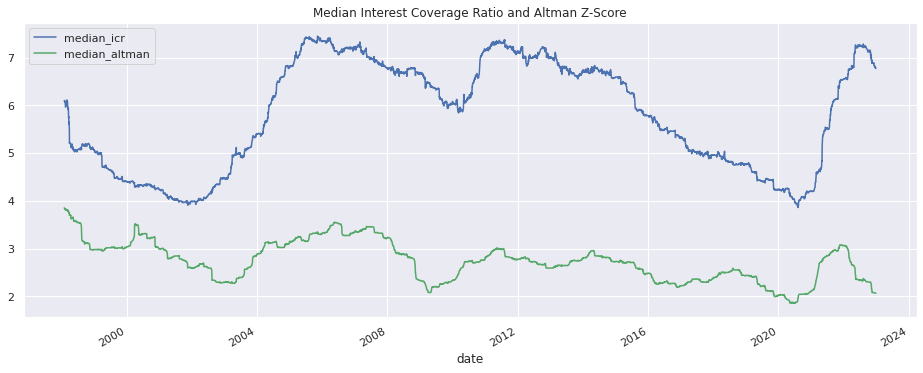

In [13]:
summary[['median_icr', 'median_altman']].plot(title="Median Interest Coverage Ratio and Altman Z-Score");

And we'll plot the percentage of companies that are zombies and the percentage that are distressed in another chart:

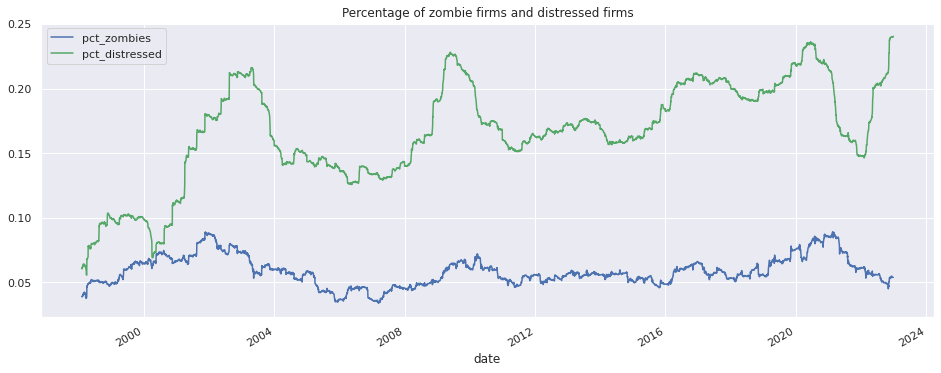

In [14]:
summary[['pct_zombies', 'pct_distressed']].plot(title="Percentage of zombie firms and distressed firms");

***

## *Next Up*

Lesson 11: [Alphalens: Altman Z-Score](Lesson11-Altman-Z-Score.ipynb)